In [1]:
!rm -rf __MACOSX
!rm -rf 10_food_classes_10_percent
!rm -rf model_checkpoint

In [2]:
!nvidia-smi

Sun Oct 27 17:41:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     Off |   00000000:01:00.0  On |                  N/A |
|  0%   53C    P8              7W /  165W |     943MiB /  16380MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 05. Transfer Learning in TensorFlow Part 2: Fine-tuning Exercises

1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?

3. Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?

4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.


## 1. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

### Download and extract the data

In [3]:
# Get 10% of training data of 10 classes of Food101
!rm -rf 10_food_classes_10_percent*
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

import zipfile

zipref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zipref.extractall()
zipref.close()

!rm -rf 10_food_classes_10_percent.zip      

--2024-10-27 17:41:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.209.187, 216.58.210.187, 216.58.211.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.209.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  35.5MB/s    in 5.4s    

2024-10-27 17:41:20 (29.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



### Create train and test data layers

In [4]:
import tensorflow as tf

In [5]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [6]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir_10_percent = "10_food_classes_10_percent/test"

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir_10_percent,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode="categorical"
)

test_data_10_percent =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir_10_percent,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode="categorical"
)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Create `ModelCheckpoint` callback

In [7]:
checkpoint_path = "model_checkpoint/checkpoint.ckpt"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only=False,
    save_weights_only=True,
    save_freq="epoch",
    verbose=1
)

### Create Model 1

In [8]:
input_shape = IMG_SIZE + (3,)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(input_shape, name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model_1 = tf.keras.models.Model(inputs, outputs)

### Compile Model 1

In [9]:
model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

### Fit Model 1

In [10]:
model_1_history = model_1.fit(
    train_data_10_percent,
    epochs=10,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent)),
    callbacks=[model_checkpoint_callback]
)
model_1.evaluate(test_data_10_percent)

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9110 - accuracy: 0.3960
Epoch 1: saving model to model_checkpoint/checkpoint.ckpt
24/24 [==============================] - 8s 128ms/step - loss: 1.9110 - accuracy: 0.3960 - val_loss: 1.3663 - val_accuracy: 0.6826
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.0999 - accuracy: 0.7595
Epoch 2: saving model to model_checkpoint/checkpoint.ckpt
24/24 [==============================] - 2s 78ms/step - loss: 1.0979 - accuracy: 0.7587 - val_loss: 0.9201 - val_accuracy: 0.7944
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7779 - accuracy: 0.8329
Epoch 3: saving model to model_checkpoint/checkpoint.ckpt
24/24 [==============================] - 2s 77ms/step - loss: 0.7789 - accuracy: 0.8320 - val_loss: 0.7318 - val_accuracy: 0.8306
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.6213 - accuracy: 0.8696
Epoch 4: saving model to model_checkpoint/checkpoint.ckpt
2

[0.4488908350467682, 0.871999979019165]

## 2. Fine-tune the last 20 layers of the base model you trained in 1 for another 10 epochs. How did it go?

### Create Fine-Tune version of the model

#### Create base model

In [11]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

#### Create model

In [12]:
inputs = tf.keras.layers.Input(input_shape, name="inputs")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model_2 = tf.keras.models.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)

### Compile the model

In [13]:
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
    metrics=["accuracy"]
)

### Fit the model

In [14]:
model_2_history = model_2.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=20,
    initial_epoch=model_1_history.epoch[-1],
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent))
)

Epoch 10/20
24/24 [==============================] - 11s 164ms/step - loss: 0.6953 - accuracy: 0.7773 - val_loss: 0.6271 - val_accuracy: 0.7829
Epoch 11/20
24/24 [==============================] - 2s 74ms/step - loss: 0.2595 - accuracy: 0.9280 - val_loss: 0.7100 - val_accuracy: 0.8224
Epoch 12/20
24/24 [==============================] - 2s 75ms/step - loss: 0.0992 - accuracy: 0.9733 - val_loss: 0.6669 - val_accuracy: 0.8240
Epoch 13/20
24/24 [==============================] - 2s 75ms/step - loss: 0.0446 - accuracy: 0.9893 - val_loss: 0.6502 - val_accuracy: 0.8487
Epoch 14/20
24/24 [==============================] - 2s 75ms/step - loss: 0.0284 - accuracy: 0.9933 - val_loss: 0.5592 - val_accuracy: 0.8668
Epoch 15/20
24/24 [==============================] - 2s 74ms/step - loss: 0.0156 - accuracy: 0.9947 - val_loss: 0.6514 - val_accuracy: 0.8553
Epoch 16/20
24/24 [==============================] - 2s 75ms/step - loss: 0.0164 - accuracy: 0.9947 - val_loss: 0.7352 - val_accuracy: 0.8240
Epoc

### How did it perform?

In [15]:
print(f"Model 1 score: {model_1.evaluate(test_data_10_percent)}\nModel 2 score: {model_2.evaluate(test_data_10_percent)}")

79/79 [==============================] - 3s 39ms/step - loss: 0.5655 - accuracy: 0.8800
Model 1 score: [0.4488905668258667, 0.871999979019165]
Model 2 score: [0.5654855370521545, 0.8799999952316284]


Model 2 performed about the same as model 1

## 3. Fine-tune the last 30 layers of the base model you trained in 1 for another 10 epochs. How did it go?

### Create Model 3

#### Create base model

In [16]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

#### Create the model

In [17]:
inputs = tf.keras.layers.Input(input_shape, name="inputs")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

model_3 = tf.keras.models.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

### Compile Model 3

In [18]:
model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4),
    metrics=["accuracy"]
)

### Fit Model 3

In [19]:
model_3_history = model_3.fit(
    train_data_10_percent,
    steps_per_epoch=len(train_data_10_percent),
    epochs=20,
    initial_epoch=model_1_history.epoch[-1],
    validation_data=test_data_10_percent,
    validation_steps=int(0.25 * len(test_data_10_percent))
)

Epoch 10/20
24/24 [==============================] - 9s 128ms/step - loss: 0.7913 - accuracy: 0.7707 - val_loss: 0.5941 - val_accuracy: 0.8174
Epoch 11/20
24/24 [==============================] - 2s 77ms/step - loss: 0.2190 - accuracy: 0.9200 - val_loss: 0.6042 - val_accuracy: 0.8355
Epoch 12/20
24/24 [==============================] - 2s 76ms/step - loss: 0.0923 - accuracy: 0.9800 - val_loss: 0.5203 - val_accuracy: 0.8651
Epoch 13/20
24/24 [==============================] - 2s 76ms/step - loss: 0.0249 - accuracy: 0.9907 - val_loss: 0.5310 - val_accuracy: 0.8668
Epoch 14/20
24/24 [==============================] - 2s 76ms/step - loss: 0.0323 - accuracy: 0.9920 - val_loss: 0.6773 - val_accuracy: 0.8339
Epoch 15/20
24/24 [==============================] - 2s 77ms/step - loss: 0.0303 - accuracy: 0.9867 - val_loss: 0.6821 - val_accuracy: 0.8470
Epoch 16/20
24/24 [==============================] - 2s 76ms/step - loss: 0.0657 - accuracy: 0.9840 - val_loss: 0.5360 - val_accuracy: 0.8668
Epoch

### How did it perform?

In [20]:
print(f"Model 1 score: {model_1.evaluate(test_data_10_percent)}\nModel 2 score: {model_2.evaluate(test_data_10_percent)}\nModel 3 score: {model_3.evaluate(test_data_10_percent)}")

79/79 [==============================] - 3s 39ms/step - loss: 0.5760 - accuracy: 0.8768
Model 1 score: [0.4488903880119324, 0.871999979019165]
Model 2 score: [0.5654853582382202, 0.8799999952316284]
Model 3 score: [0.5759916305541992, 0.876800000667572]


Model 3 performed about the same as model 2

## 4. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [21]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def visualize_and_predict_image(dataset, amount):
    amount = amount if amount > 0 and amount < BATCH_SIZE else BATCH_SIZE
    imgs, labels = dataset.as_numpy_iterator().next()
    plt.figure(figsize=(12,3*amount))
    for i in range(amount):
        plt.subplot(amount,4,i*4+1)
        plt.imshow(imgs[i]/255)
        plt.title(f"Model 1: {dataset.class_names[model_1.predict(tf.expand_dims(imgs[i], axis=0)).argmax()]}")
        plt.axis(False)
        plt.subplot(amount,4,i*4+2)
        plt.imshow(imgs[i]/255)
        plt.title(f"Model 2: {dataset.class_names[model_2.predict(tf.expand_dims(imgs[i], axis=0)).argmax()]}")
        plt.axis(False)
        plt.subplot(amount,4,i*4+3)
        plt.imshow(imgs[i]/255)
        plt.title(f"Model 3: {dataset.class_names[model_3.predict(tf.expand_dims(imgs[i], axis=0)).argmax()]}")
        plt.axis(False)
        plt.subplot(amount,4,i*4+4)
        plt.imshow(imgs[i]/255)
        plt.title(f"Actual: {dataset.class_names[labels[i].argmax()]}")
        plt.axis(False)

1/1 [==============================] - 0s 13ms/step


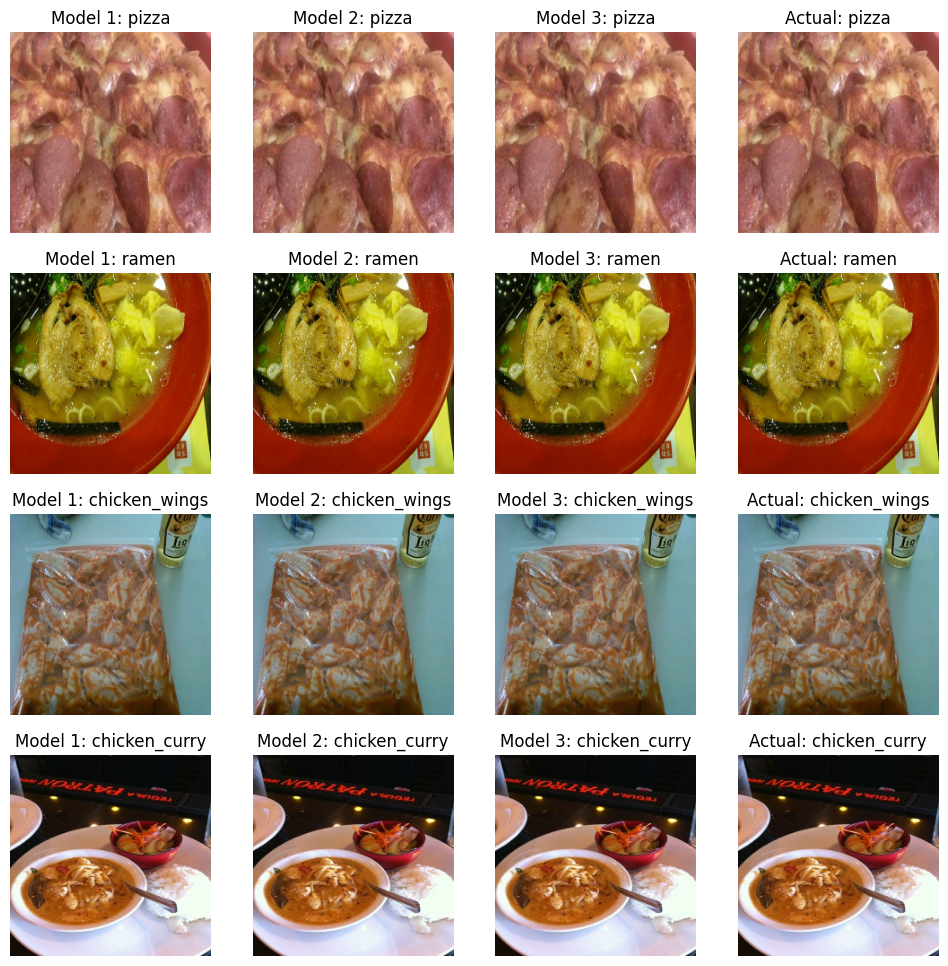

In [22]:
visualize_and_predict_image(train_data_10_percent, 4)

In [23]:
!rm -rf __MACOSX
!rm -rf 10_food_classes_10_percent
!rm -rf model_checkpoint